In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  

import numpy as np
import scipy.interpolate as interp 
try:
    import cupy as xp
    import cupyx.scipy.interpolate as xinterp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    import scipy.interpolate as xinterp  
    # print("no cupy")

from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
# matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import *
from Triangle.Data import * 

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

# import multiprocessing

# np.random.seed(114514)
# xp.random.seed(114514)

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


has cupy
has cupy
has BBHx waveform


## Data settings 

In [2]:
t_start = 100. * DAY # start time in s
Tobs = 5. * DAY # data length in s 
t_end = t_start + Tobs # end time in s 
dt = 15. # time cadance in s 
fsample = 1. / dt # sampling rate in Hz 
data_frequencies_full = np.fft.rfftfreq(n=int(Tobs/dt), d=dt) # frequecies where waveform will be calculated 
delta_f = 1. / Tobs

data_frequencies_full.shape 

(14401,)

In [3]:
# mask the "null" frequencies, which may cause singularity in the calculation of likelihood 
mask = np.ones_like(data_frequencies_full, dtype=bool)
for i in range(1, 50): 
    mask_idx = np.where(np.abs(data_frequencies_full - i*0.025)<i*5e-4)[0]
    mask[mask_idx] = False 

# remove the frequencies below Taiji sensitive band 
mask_idx = np.where(data_frequencies_full < 1e-5)[0]
mask[mask_idx] = False 

data_frequencies = data_frequencies_full[mask]
data_frequencies_GPU = xp.array(data_frequencies)

valid_idx = np.where(mask == True)[0]

data_frequencies.shape, valid_idx.shape 

((13964,), (13964,))

## Set response model 

In [4]:
# the path of Taiji orbit 
orbit_GPU = Orbit(OrbitDir="../../Triangle-Simulator/OrbitData/MicroSateOrbitEclipticTCB") # create individial orbit objects for CPU and GPU to avoid the confusion of numpy / cupy orbit data 

# initialize  waveform generator 
WFG_GPU = BBHxWaveformGenerator(mode="primary", use_gpu=True)

# initialize response generator 
FDTDI_GPU = BBHxFDTDIResponseGenerator(orbit_class=orbit_GPU, waveform_generator=WFG_GPU, use_gpu=True)

# response settings 
response_kwargs_GPU = dict(
    modes=[(2,2)], 
    tc_at_constellation=True,
    tmin=t_start / DAY, # start time in day 
    tmax=t_end / DAY, # end time in day  
    TDIGeneration="2nd", # "1st" or "2nd"
    optimal_combination=True, # True for AET, False for XYZ 
    output_by_mode=False, 
    interpolation=True,
    # interpolation=False, 
)

## Source parameter priors 

In [5]:
lgMc_prior = [5.5, 6.5]
q_prior = [0.1, 1]
s1_prior = [-0.9, 0.9]
s2_prior = [-0.9, 0.9]
tc_prior = [t_start/DAY+3., t_end/DAY-1.] 
lam_prior = [0, TWOPI]
sinbeta_prior = [-1., 1.]
intrinsic_param_priors = np.array([
    lgMc_prior, 
    q_prior, 
    s1_prior, 
    s2_prior, 
    tc_prior, 
    lam_prior, 
    sinbeta_prior, 
])

lgdl_prior = [4., 5.]

intrinsic_param_priors

array([[ 5.50000000e+00,  6.50000000e+00],
       [ 1.00000000e-01,  1.00000000e+00],
       [-9.00000000e-01,  9.00000000e-01],
       [-9.00000000e-01,  9.00000000e-01],
       [ 1.03000000e+02,  1.04000000e+02],
       [ 0.00000000e+00,  6.28318531e+00],
       [-1.00000000e+00,  1.00000000e+00]])

In [6]:
tc_prior

[103.0, 104.0]

## Noise model 

In [7]:
arm_time = np.mean(intrinsic_param_priors[4]) * DAY 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit_GPU.LTTfunctions()[key](arm_time)
print(arm_time/DAY)

# theoretical PSDs at the given armlengths 
PSDfunc = TDIPSDs()
PSD_channels = np.array([
    PSDfunc.PSD_A2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_E2_unequal(data_frequencies, arms), 
    PSDfunc.PSD_T2_unequal(data_frequencies, arms)
])

# covariance matrix 
CovMat = np.array([
    [PSD_channels[0], np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), PSD_channels[1], np.zeros_like(PSD_channels[0])],
    [np.zeros_like(PSD_channels[0]), np.zeros_like(PSD_channels[0]), PSD_channels[2]]
]) / 4. / delta_f # (3, 3, Nf)

# inverse of covmatrix
InvCovMat = np.linalg.inv(np.transpose(CovMat, (2, 0, 1))) # (Nf, 3, 3)
InvCovMat[:, 2, 2] *= 0. # use A, E channels only in the following analysis 

PSD_channels.shape, InvCovMat.shape 

103.5


((3, 13964), (13964, 3, 3))

## Data simulation 

In [8]:
# generate source parameter and clean signal 
mbhb_parameters = {
    'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    'coalescence_phase': np.random.uniform(0, TWOPI),
    'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    'psi': np.random.uniform(0, PI) # [rad]
    }
wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

# generate frequency-domain noises 
Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

# combine signal and noise 
data_channels = wf_channels + noise_channels 
# data_channels = wf_channels

opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)

print("source parameters:")
for k, v in mbhb_parameters.items():
    print(k, ":", v)
print("optimal SNR:", opt_SNR)

source parameters:
chirp_mass : 1605896.0112329763
mass_ratio : 0.9373656784837475
spin_1z : -0.7978628448111917
spin_2z : 0.7327980889444344
coalescence_time : 103.07789159893234
coalescence_phase : 3.6181590730626665
luminosity_distance : 60938.94934854844
inclination : 2.6949257483888376
longitude : 1.6010292925865661
latitude : -0.8695708236385266
psi : 0.3674669227455661
optimal SNR: 1605.6426742270698


Text(0, 0.5, 'Frequency-domain data (1/Hz)')

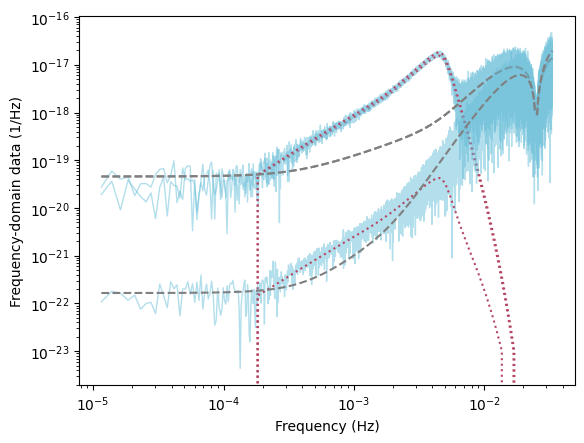

In [9]:
for ichannel, nchannel in enumerate(["A", "E", "T"]): 
    plt.loglog(data_frequencies, np.abs(data_channels[ichannel].get()), linewidth=1, alpha=0.5, color=BLUE)
    plt.loglog(data_frequencies, np.abs(wf_channels[ichannel].get()), color=RED, linestyle=":")
    plt.loglog(data_frequencies, np.sqrt(PSD_channels[ichannel] * Tobs / 2.), color="grey", linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Frequency-domain data (1/Hz)")

## MLE with  $\mathcal{F}$-stat 

In [10]:
Fstat = Fstatistics(
    response_generator=FDTDI_GPU, 
    frequency=data_frequencies_GPU, 
    data=data_channels, 
    # data=wf_channels,
    invserse_covariance_matrix=InvCovMat, 
    response_parameters=response_kwargs_GPU, 
    use_gpu=True
)

### test waveform and parameter recovery

In [11]:
int_params = dict()
for key in Fstatistics.intrinsic_parameter_names:
    int_params[key] = mbhb_parameters[key]
int_params

{'chirp_mass': 1605896.0112329763,
 'mass_ratio': 0.9373656784837475,
 'spin_1z': -0.7978628448111917,
 'spin_2z': 0.7327980889444344,
 'coalescence_time': 103.07789159893234,
 'longitude': 1.6010292925865661,
 'latitude': -0.8695708236385266}

In [12]:
rec_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_a=True, 
)

rec_ext_params = Fstat.a_to_extrinsic_vectorized(rec_a)

rec_params = dict(int_params, **rec_ext_params)

print("parameter name | difference")
for k, v in rec_ext_params.items():
    print(k, ":", v-mbhb_parameters[k])

rec_a.shape

parameter name | difference
luminosity_distance : -298.5251008693958
inclination : -0.010346030974999199
psi : 1.4713184147338354
coalescence_phase : -1.4717056055720623


(1, 4)

In [13]:
rec_wave1 = FDTDI_GPU.Response(
    rec_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

rec_wave2 = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=int_params, 
    return_recovered_wave=True, 
)

rec_wave1.shape, rec_wave2.shape 

((3, 13964), (3, 13964))

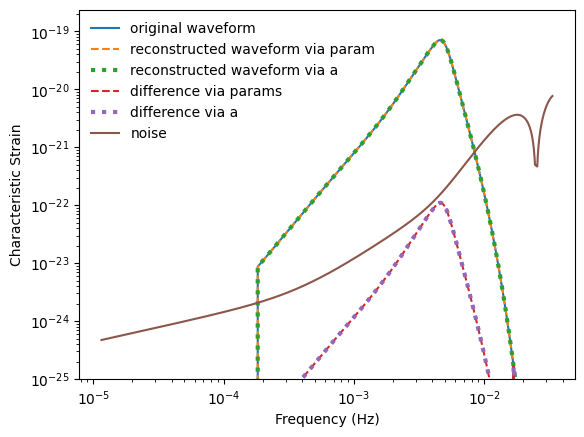

In [14]:
plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="original waveform")
plt.loglog(data_frequencies, np.abs(rec_wave1[0].get()) * data_frequencies, linestyle="--", label="reconstructed waveform via param")
plt.loglog(data_frequencies, np.abs(rec_wave2[0].get()) * data_frequencies, linestyle=":", label="reconstructed waveform via a", linewidth=3)

plt.loglog(data_frequencies, np.abs(rec_wave1[0].get() - wf_channels[0].get()) * data_frequencies, label="difference via params", linestyle="--")
plt.loglog(data_frequencies, np.abs(rec_wave2[0].get() - wf_channels[0].get()) * data_frequencies, label="difference via a", linestyle=":", linewidth=3)
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25,)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend(loc="upper left", frameon=False)

### optimization from prior 

In [15]:
from scipy.optimize import differential_evolution

def cost_function(norm_int_params):
    """   
        norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
    """
    int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
    params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
    return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

n_dim_int = 7 
lower_bounds = np.zeros(n_dim_int) 
upper_bounds = np.ones(n_dim_int) 
bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

DE_result = differential_evolution(
    func=cost_function,
    bounds=bounds,
    x0=None,
    strategy='best1exp',
    # strategy='rand1bin',
    maxiter=5000,
    popsize=10*n_dim_int,
    # popsize=6*n_dim_int, 
    tol=1e-8,
    atol=1e-10,
    # tol=1e-7,
    # atol=1e-9,
    # tol=1e-6,
    # atol=1e-8,
    mutation=(0.4, 0.95),
    recombination=0.7,
    disp=False,
    polish=True,
    vectorized=True,
    # workers=1,
)

print(DE_result)

/home/ps/miniconda3/envs/tdc/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'vectorized' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


             message: Optimization terminated successfully.
             success: True
                 fun: -1289517.9154571355
                   x: [ 7.058e-01  9.292e-01  8.167e-02  8.810e-01
                        7.423e-02  1.352e-01  3.244e-01]
                 nit: 501
                nfev: 534
          population: [[ 7.058e-01  9.292e-01 ...  1.352e-01  3.244e-01]
                       [ 7.058e-01  9.296e-01 ...  1.355e-01  3.239e-01]
                       ...
                       [ 7.058e-01  9.296e-01 ...  1.351e-01  3.236e-01]
                       [ 7.058e-01  9.295e-01 ...  1.351e-01  3.242e-01]]
 population_energies: [-1.290e+06 -1.290e+06 ... -1.290e+06 -1.290e+06]
                 jac: [ 8.661e+00  4.261e+00  6.962e+00  5.076e+00
                       -2.934e+00  9.297e+01 -1.031e+01]


### reconstruct parameters and waveforms 

In [16]:
from copy import deepcopy

# get MLE params
searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])
searched_a = Fstat.calculate_Fstat_vectorized(
    intrinsic_parameters=searched_int_params, 
    return_a=True, 
) # (1, 4)
searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)
searched_params = dict(searched_int_params, **searched_ext_params)

# get reflected params 
lon_ssb = searched_params["longitude"]
lat_ssb = searched_params["latitude"]
psi_ssb = searched_params["psi"]
lon_det, lat_det, psi_det = SSBPosToDetectorFrame(lon_ssb, lat_ssb, psi_ssb, searched_params["coalescence_time"]*DAY, orbit_GPU)
lat_det = -lat_det # reflect latitutde 
psi_det = PI - psi_det # reflect psi 
searched_ref_params = deepcopy(searched_params)
searched_ref_params["longitude"], searched_ref_params["latitude"], searched_ref_params["psi"] = DetectorPosToSSBFrame(lon_det, lat_det, psi_det, searched_params["coalescence_time"]*DAY, orbit_GPU)
searched_ref_params["inclination"] = PI - searched_params["inclination"] # reflect inclination 

print("parameter name | true value | searched value | searched value (reflection)")
for k, v in searched_params.items():
    print(k, mbhb_parameters[k], v, searched_ref_params[k])

parameter name | true value | searched value | searched value (reflection)
chirp_mass 1605896.0112329763 1606358.1936511667 1606358.1936511667
mass_ratio 0.9373656784837475 0.9363114420412237 0.9363114420412237
spin_1z -0.7978628448111917 -0.7529913307986923 -0.7529913307986923
spin_2z 0.7327980889444344 0.6857524619938876 0.6857524619938876
coalescence_time 103.07789159893234 103.07422966094465 103.07422966094465
longitude 1.6010292925865661 0.8495573385353278 1.6236848348477668
latitude -0.8695708236385266 -0.35895009357540714 -0.8190266337297327
luminosity_distance 60938.94934854844 44320.11238698467 44320.11238698467
inclination 2.6949257483888376 0.8915737341473388 2.2500189194424545
psi 0.3674669227455661 2.8199714752465845 1.5059761176127564
coalescence_phase 3.6181590730626665 2.4225464444511466 2.4225464444511466


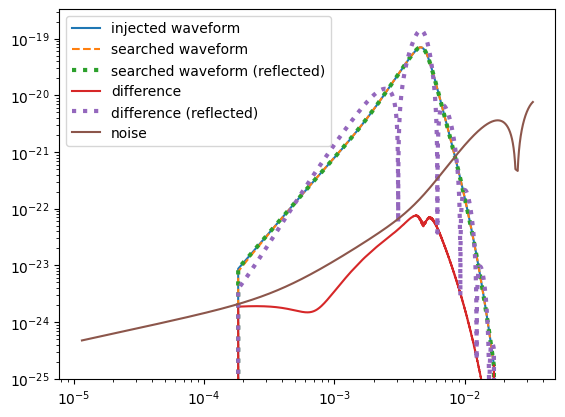

In [17]:
searched_wf1 = FDTDI_GPU.Response(
    searched_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

# searched_ref_params["psi"] = mbhb_parameters["psi"]
searched_wf2 = FDTDI_GPU.Response(
    searched_ref_params, 
    data_frequencies_GPU, 
    **response_kwargs_GPU
)

plt.loglog(data_frequencies, np.abs(wf_channels[0].get()) * data_frequencies, label="injected waveform")
plt.loglog(data_frequencies, np.abs(searched_wf1[0].get()) * data_frequencies, linestyle="--", label="searched waveform")
plt.loglog(data_frequencies, np.abs(searched_wf2[0].get()) * data_frequencies, linestyle=":", label="searched waveform (reflected)", linewidth=3)
plt.loglog(data_frequencies, np.abs(searched_wf1[0].get() - wf_channels[0].get()) * data_frequencies, linestyle="-", label="difference")
plt.loglog(data_frequencies, np.abs(searched_wf2[0].get() - wf_channels[0].get()) * data_frequencies, linestyle=":", label="difference (reflected)", linewidth=3)
plt.loglog(data_frequencies, np.sqrt(PSD_channels[0] * 2. * data_frequencies), label="noise")
plt.ylim(1e-25, )
plt.legend()

(0.99, 1.01)

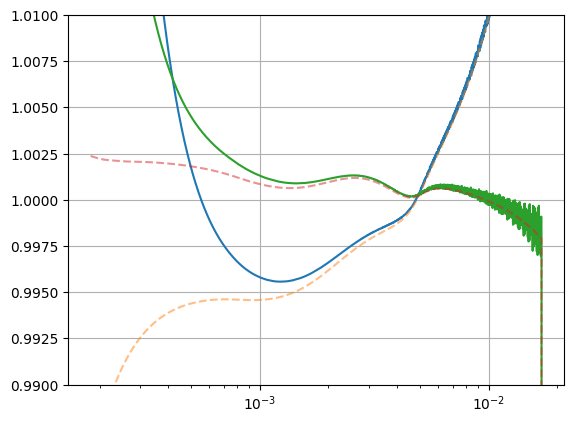

In [18]:
for i in range(2):
    plt.semilogx(data_frequencies, np.abs((wf_channels[i] / searched_wf1[i]).get()))
    plt.semilogx(data_frequencies, np.abs((wf_channels[i] / searched_wf2[i]).get()), linestyle="--", alpha=0.5)
plt.grid()
plt.ylim(0.99, 1.01)

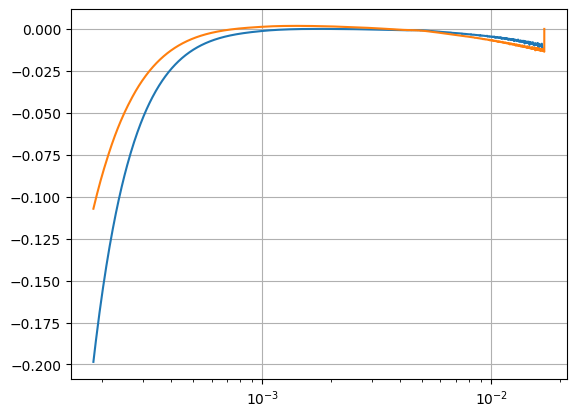

In [19]:
for i in range(2):
    plt.semilogx(data_frequencies, np.angle((wf_channels[i] / searched_wf1[i]).get()))
    # plt.semilogx(data_frequencies, np.unwrap(np.angle((wf_channels[i] / searched_wf2[i]).get())), linestyle="--", alpha=0.5)
plt.grid()

## Fisher analysis 

In [20]:
def fisher_waveform_wrapper(param_dict, frequencies):
    res = FDTDI_GPU.Response(
        parameters=param_dict, 
        freqs=xp.array(frequencies),  
        **response_kwargs_GPU, 
    )
    return res.get()

# set initial steps 
analyze_param_step_dict = {
    'chirp_mass': 10.,
    'mass_ratio': 0.01,
    'spin_1z': 0.01,
    'spin_2z': 0.01,
    'coalescence_time': 0.001,
    'coalescence_phase': 0.1,
    'luminosity_distance': 1.,
    'inclination': 0.01,
    'longitude': 0.01,
    'latitude': 0.01,
    'psi': 0.01
    }
for k, v in analyze_param_step_dict.items():
    analyze_param_step_dict[k] = -v 

FIM = MultiChannelFisher(
    waveform_generator=fisher_waveform_wrapper, 
    param_dict=mbhb_parameters, 
    # param_dict=searched_params, 
    analyze_param_step_dict=analyze_param_step_dict, 
    frequency=data_frequencies, 
    inverse_covariance=InvCovMat, 
    verbose=0,
)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors() 

FIM.param_errors

{'chirp_mass': 762.5655374639392,
 'mass_ratio': 0.007969556178927006,
 'spin_1z': 0.11283800514893276,
 'spin_2z': 0.11480122806604741,
 'coalescence_time': 0.00011719692310273262,
 'coalescence_phase': 3.084881873930928,
 'luminosity_distance': 22756.31147753651,
 'inclination': 0.9389692046218973,
 'longitude': 0.03126014041695215,
 'latitude': 0.03627505173844316,
 'psi': 3.116291154057931}

In [21]:
print("parameter name | difference | difference (ref) | FIM bound")
for k, v in searched_params.items():
    print(k, np.abs(v-mbhb_parameters[k]), np.abs(searched_ref_params[k] - mbhb_parameters[k]), FIM.param_errors[k])

parameter name | difference | difference (ref) | FIM bound
chirp_mass 462.1824181904085 462.1824181904085 762.5655374639392
mass_ratio 0.0010542364425237816 0.0010542364425237816 0.007969556178927006
spin_1z 0.04487151401249945 0.04487151401249945 0.11283800514893276
spin_2z 0.047045626950546815 0.047045626950546815 0.11480122806604741
coalescence_time 0.0036619379876867697 0.0036619379876867697 0.00011719692310273262
longitude 0.7514719540512383 0.0226555422612007 0.03126014041695215
latitude 0.5106207300631194 0.050544189908793835 0.03627505173844316
luminosity_distance 16618.83696156377 16618.83696156377 22756.31147753651
inclination 1.803352014241499 0.4449068289463831 0.9389692046218973
psi 2.4525045525010185 1.1385091948671904 3.116291154057931
coalescence_phase 1.1956126286115198 1.1956126286115198 3.084881873930928


## Test across population 

In [22]:
truths_list = [] 
searched_list = [] 
FIM_bound_list = [] 
snr_list = [] 
res_snr_list = []

for test_idx in tqdm(range(10)):

    # generate source parameter and clean signal 
    # mbhb_parameters = {
    #     'chirp_mass': np.power(10., np.random.uniform(lgMc_prior[0], lgMc_prior[1])), 
    #     'mass_ratio': np.random.uniform(q_prior[0], q_prior[1]), 
    #     'spin_1z': np.random.uniform(s1_prior[0], s1_prior[1]),
    #     'spin_2z': np.random.uniform(s2_prior[0], s2_prior[1]),
    #     'coalescence_time': np.random.uniform(tc_prior[0], tc_prior[1]), 
    #     'coalescence_phase': np.random.uniform(0, TWOPI),
    #     'luminosity_distance': np.power(10., np.random.uniform(lgdl_prior[0], lgdl_prior[1])), 
    #     'inclination': np.arccos(np.random.uniform(-1., 1.)), # [rad]
    #     'longitude': np.random.uniform(lam_prior[0], lam_prior[1]), # [rad]
    #     'latitude': np.arcsin(np.random.uniform(sinbeta_prior[0], sinbeta_prior[1])), # [rad]
    #     'psi': np.random.uniform(0, PI) # [rad]
    #     }
    wf_channels = FDTDI_GPU.Response(mbhb_parameters, data_frequencies_GPU, **response_kwargs_GPU)

    # generate frequency-domain noises 
    Re_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    Im_tmp = np.random.normal(scale=np.sqrt(PSD_channels / 4. / delta_f))
    noise_channels = xp.array(Re_tmp + 1.j * Im_tmp) 

    # combine signal and noise 
    data_channels = wf_channels + noise_channels 
    # data_channels = wf_channels

    opt_SNR = FrequencyDomainCovarianceSNR(wf_channels.get(), InvCovMat)
    snr_list.append(opt_SNR)

    Fstat = Fstatistics(
        response_generator=FDTDI_GPU, 
        frequency=data_frequencies_GPU, 
        data=data_channels, 
        invserse_covariance_matrix=InvCovMat, 
        response_parameters=response_kwargs_GPU, 
        use_gpu=True
    )

    def cost_function(norm_int_params):
        """   
            norm_int_params: shape (Nparams, Nevent), normalized to (0, 1)
        """
        int_params = norm_int_params.transpose() * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0] # (Nevent, Nparams)
        params_in = Fstat.IntParamArr2ParamDict(int_params.transpose()) # (Nparams, Nevent) -> dictionary, each item (Nevent)
        return -Fstat.calculate_Fstat_vectorized(intrinsic_parameters=params_in) # (Nevent)

    n_dim_int = 7 
    lower_bounds = np.zeros(n_dim_int) 
    upper_bounds = np.ones(n_dim_int) 
    bounds = np.array([lower_bounds, upper_bounds]).T # (Nparams, 2)

    DE_result = differential_evolution(
        func=cost_function,
        bounds=bounds,
        x0=None,
        strategy='best1exp',
        # strategy='rand1bin',
        maxiter=5000,
        popsize=10*n_dim_int,
        # popsize=6*n_dim_int, 
        tol=1e-8,
        atol=1e-10,
        # tol=1e-6,
        # atol=1e-8,
        mutation=(0.4, 0.95),
        recombination=0.7,
        disp=False,
        polish=False,
        vectorized=True,
    )

    searched_int_params = Fstat.IntParamArr2ParamDict(DE_result.x * (intrinsic_param_priors[:, 1] - intrinsic_param_priors[:, 0]) + intrinsic_param_priors[:, 0])

    searched_a = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_a=True, 
    ) # (1, 4)
    searched_ext_params = Fstat.a_to_extrinsic_vectorized(searched_a)

    searched_params = dict(searched_int_params, **searched_ext_params)

    searched_wf = Fstat.calculate_Fstat_vectorized(
        intrinsic_parameters=searched_int_params, 
        return_recovered_wave=True, 
    )[:, 0, :]
    res_snr_list.append(FrequencyDomainCovarianceSNR((wf_channels-searched_wf).get(), InvCovMat))

    def fisher_waveform_wrapper(param_dict, frequencies):
        res = FDTDI_GPU.Response(
            parameters=param_dict, 
            freqs=xp.array(frequencies),  
            **response_kwargs_GPU, 
        )
        return res.get()

    # set initial steps 
    analyze_param_step_dict = {
        'chirp_mass': 10.,
        'mass_ratio': 0.01,
        'spin_1z': 0.01,
        'spin_2z': 0.01,
        'coalescence_time': 0.001,
        'coalescence_phase': 0.01,
        'luminosity_distance': 10.,
        'inclination': 0.01,
        'longitude': 0.01,
        'latitude': 0.01,
        'psi': 0.01
        }
    for k, v in analyze_param_step_dict.items():
        analyze_param_step_dict[k] = -v 

    FIM = MultiChannelFisher(
        waveform_generator=fisher_waveform_wrapper, 
        param_dict=mbhb_parameters, 
        # param_dict=searched_params, 
        analyze_param_step_dict=analyze_param_step_dict, 
        frequency=data_frequencies, 
        inverse_covariance=InvCovMat, 
        verbose=0,
    )

    FIM.auto_test_step()
    FIM.calculate_Fisher()
    FIM.calculate_errors() 

    truths_list.append(mbhb_parameters)
    searched_list.append(searched_params)
    FIM_bound_list.append(FIM.param_errors)
    print("optimal snr =", snr_list[test_idx])
    print("residual snr =", res_snr_list[test_idx])
    print("tc deviation =", searched_list[test_idx]["coalescence_time"]-truths_list[test_idx]["coalescence_time"])
    print("tc bound =", FIM_bound_list[test_idx]["coalescence_time"])
    print("longitude deviation=", searched_list[test_idx]["longitude"] - truths_list[test_idx]["longitude"])
    print("latitude deviation=", searched_list[test_idx]["latitude"] - truths_list[test_idx]["latitude"])
    print("inclination deviation=", searched_list[test_idx]["inclination"] - truths_list[test_idx]["inclination"])
    print("inclination sum=", searched_list[test_idx]["inclination"] + truths_list[test_idx]["inclination"])

  0%|          | 0/10 [01:39<?, ?it/s]


KeyboardInterrupt: 

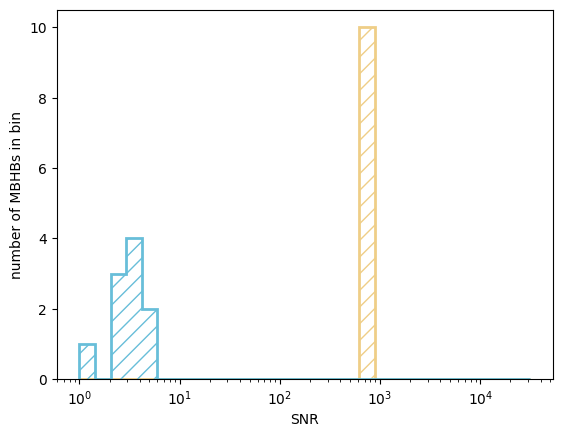

In [ ]:
bins = np.logspace(0., 4.5, 30)
plt.hist(snr_list, bins=bins, density=False, facecolor=None, edgecolor=YELLOW, hatch="//", histtype='step', lw=2); 
plt.hist(res_snr_list, bins=bins, density=False, facecolor=None, edgecolor=BLUE, hatch="//", histtype='step', lw=2); 
plt.xlabel("SNR")
plt.ylabel("number of MBHBs in bin")
plt.xscale("log")

In [ ]:
Mc_list = np.array([paramdict["chirp_mass"] for paramdict in truths_list])
q_list = np.array([paramdict["mass_ratio"] for paramdict in truths_list])
s1_list = np.array([paramdict["spin_1z"] for paramdict in truths_list])
s2_list = np.array([paramdict["spin_2z"] for paramdict in truths_list])
tc_list = np.array([paramdict["coalescence_time"] for paramdict in truths_list])
dl_list = np.array([paramdict["luminosity_distance"] for paramdict in truths_list])
inc_list = np.array([paramdict["inclination"] for paramdict in truths_list])
lon_list = np.array([paramdict["longitude"] for paramdict in truths_list])
lat_list = np.array([paramdict["latitude"] for paramdict in truths_list])

Mc_list1 = np.array([paramdict["chirp_mass"] for paramdict in searched_list])
q_list1 = np.array([paramdict["mass_ratio"] for paramdict in searched_list])
s1_list1 = np.array([paramdict["spin_1z"] for paramdict in searched_list])
s2_list1 = np.array([paramdict["spin_2z"] for paramdict in searched_list])
tc_list1 = np.array([paramdict["coalescence_time"] for paramdict in searched_list])
dl_list1 = np.array([paramdict["luminosity_distance"] for paramdict in searched_list])
inc_list1 = np.array([paramdict["inclination"] for paramdict in searched_list])
lon_list1 = np.array([paramdict["longitude"] for paramdict in searched_list])
lat_list1 = np.array([paramdict["latitude"] for paramdict in searched_list])

Mc_list2 = np.array([paramdict["chirp_mass"] for paramdict in FIM_bound_list])
q_list2 = np.array([paramdict["mass_ratio"] for paramdict in FIM_bound_list])
s1_list2 = np.array([paramdict["spin_1z"] for paramdict in FIM_bound_list])
s2_list2 = np.array([paramdict["spin_2z"] for paramdict in FIM_bound_list])
tc_list2 = np.array([paramdict["coalescence_time"] for paramdict in FIM_bound_list])
dl_list2 = np.array([paramdict["luminosity_distance"] for paramdict in FIM_bound_list])
inc_list2 = np.array([paramdict["inclination"] for paramdict in FIM_bound_list])
lon_list2 = np.array([paramdict["longitude"] for paramdict in FIM_bound_list])
lat_list2 = np.array([paramdict["latitude"] for paramdict in FIM_bound_list])

In [ ]:
# def DetectorBasisInSSB(orbit_time_SI, orbit):
#     n21 = orbit.ArmVectorfunctions()["21"](orbit_time_SI)
#     n31 = orbit.ArmVectorfunctions()["31"](orbit_time_SI)
#     z_det = np.cross(n31, n21)
#     z_norm = np.linalg.norm(z_det)
#     z_det = z_det / z_norm
#     x_det = n31 
#     y_det = np.cross(z_det, x_det)
#     y_norm = np.linalg.norm(y_det)
#     y_det = y_det / y_norm
#     return x_det, y_det, z_det 

# def DetectorSSBRotationMatrices(orbit_time_SI, orbit):
#     x_det, y_det, z_det = DetectorBasisInSSB(orbit_time_SI, orbit)
#     R_det2ssb = np.array([x_det, y_det, z_det])
#     R_ssb2det = R_det2ssb.T 
#     # return R_det2ssb, R_ssb2det 
#     return R_ssb2det, R_det2ssb

# def SSBPosToDetectorFrame(lon_ssb, lat_ssb, orbit_time_SI, orbit):
#     R_det2ssb, R_ssb2det = DetectorSSBRotationMatrices(orbit_time_SI, orbit)
#     x_in_ssb = np.cos(lat_ssb) * np.cos(lon_ssb)
#     y_in_ssb = np.cos(lat_ssb) * np.sin(lon_ssb)
#     z_in_ssb = np.sin(lat_ssb)
#     x_in_det, y_in_det, z_in_det = np.matmul(R_ssb2det, np.array([x_in_ssb, y_in_ssb, z_in_ssb]))
#     lon_det = np.arctan2(y_in_det, x_in_det)
#     lat_det = np.arcsin(z_in_det)
#     return lon_det, lat_det

# def DetectorPosToSSBFrame(lon_det, lat_det, orbit_time_SI, orbit):
#     R_det2ssb, R_ssb2det = DetectorSSBRotationMatrices(orbit_time_SI, orbit)
#     x_in_det = np.cos(lat_det) * np.cos(lon_det)
#     y_in_det = np.cos(lat_det) * np.sin(lon_det)
#     z_in_det = np.sin(lat_det)
#     x_in_ssb, y_in_ssb, z_in_ssb = np.matmul(R_det2ssb, np.array([x_in_det, y_in_det, z_in_det]))
#     lon_ssb = np.arctan2(y_in_ssb, x_in_ssb) % TWOPI
#     lat_ssb = np.arcsin(z_in_ssb)
#     return lon_ssb, lat_ssb


def DetectorBasisInSSB(orbit_time_SI, orbit):
    n21 = orbit.ArmVectorfunctions()["21"](orbit_time_SI)
    n31 = orbit.ArmVectorfunctions()["31"](orbit_time_SI)
    z_det = np.cross(n31, n21)
    z_norm = np.linalg.norm(z_det)
    z_det = z_det / z_norm
    x_det = n31 
    y_det = np.cross(z_det, x_det)
    y_norm = np.linalg.norm(y_det)
    y_det = y_det / y_norm
    return x_det, y_det, z_det 

def DetectorSSBRotationMatrices(orbit_time_SI, orbit):
    x_det, y_det, z_det = DetectorBasisInSSB(orbit_time_SI, orbit)
    R_det2ssb = np.array([x_det, y_det, z_det])
    R_ssb2det = R_det2ssb.T 
    return R_det2ssb, R_ssb2det 

def SSBPosToDetectorFrame(lon_ssb, lat_ssb, orbit_time_SI, orbit):
    R_det2ssb, R_ssb2det = DetectorSSBRotationMatrices(orbit_time_SI, orbit)
    x_in_ssb = np.cos(lat_ssb) * np.cos(lon_ssb)
    y_in_ssb = np.cos(lat_ssb) * np.sin(lon_ssb)
    z_in_ssb = np.sin(lat_ssb)
    x_in_det, y_in_det, z_in_det = np.matmul(R_det2ssb, np.array([x_in_ssb, y_in_ssb, z_in_ssb]))
    lon_det = np.arctan2(y_in_det, x_in_det)
    lat_det = np.arcsin(z_in_det)
    return lon_det, lat_det

def DetectorPosToSSBFrame(lon_det, lat_det, orbit_time_SI, orbit):
    R_det2ssb, R_ssb2det = DetectorSSBRotationMatrices(orbit_time_SI, orbit)
    x_in_det = np.cos(lat_det) * np.cos(lon_det)
    y_in_det = np.cos(lat_det) * np.sin(lon_det)
    z_in_det = np.sin(lat_det)
    x_in_ssb, y_in_ssb, z_in_ssb = np.matmul(R_ssb2det, np.array([x_in_det, y_in_det, z_in_det]))
    lon_ssb = np.arctan2(y_in_ssb, x_in_ssb) % TWOPI
    lat_ssb = np.arcsin(z_in_ssb)
    return lon_ssb, lat_ssb

In [ ]:
lon_ssb = lon_list[0]
lat_ssb = lat_list[0]
# lon_ssb = np.random.uniform(0, TWOPI)
# lat_ssb = np.arcsin(np.random.uniform(-1, 1))

lon_det, lat_det = SSBPosToDetectorFrame(lon_ssb, lat_ssb, mbhb_parameters["coalescence_time"]*DAY, orbit_GPU)

# other modes 
# lon_det = (lon_det + PI)%TWOPI 
lat_det = -lat_det 

lon_ssb_rec, lat_ssb_rec = DetectorPosToSSBFrame(lon_det, lat_det, mbhb_parameters["coalescence_time"]*DAY, orbit_GPU)

lon_ssb, lon_ssb_rec, lat_ssb, lat_ssb_rec

(5.230507859680368,
 3.8257751281871117,
 0.8258907965085774,
 0.09351187780483261)

In [ ]:
inc_list, inc_list1, inc_list + inc_list1

(array([0.57267506, 0.57267506]),
 array([0.58734751, 2.5651311 ]),
 array([1.16002256, 3.13780616]))

In [ ]:
lon_list, lon_list1

(array([5.23050786, 5.23050786]), array([5.22836252, 3.8231931 ]))

In [ ]:
lat_list, lat_list1

(array([0.8258908, 0.8258908]), array([0.82959668, 0.09100155]))

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((Mc_list1 - Mc_list) / Mc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="chirp mass");
plt.hist((q_list1 - q_list) / q_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="mass ratio");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-12, 12, 50)
plt.hist((s1_list1 - s1_list) / s1_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="spin 1");
plt.hist((s2_list1 - s2_list) / s2_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="spin 2");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((lon_list1 - lon_list) / lon_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="longitude");
plt.hist((lat_list1 - lat_list) / lat_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="latitude");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((dl_list1 - dl_list) / dl_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="luminosity distance");
plt.hist((inc_list1 - inc_list) / inc_list2, bins=bins, density=False, facecolor=None, edgecolor=GREEN1, hatch="//", histtype='step', lw=2, label="inclination");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
bins = np.linspace(-100, 100, 50)
plt.hist((tc_list1 - tc_list) / tc_list2, bins=bins, density=False, facecolor=None, edgecolor=RED, hatch="//", histtype='step', lw=2, label="coalescence time");
plt.xlabel(r'$\Delta \theta / \ \sigma_{\theta}$')
plt.ylabel("number of MBHBs in bin")
plt.legend(loc="upper right", frameon=False)

In [ ]:
plt.hist(tc_list - tc_list1);
plt.xlabel("tc error")